# Import Libralies

In [89]:
# Data Manipulation
import pandas as pd

# Math thing
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# K-mean Algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix

## Read the data file

In [90]:
def read_datafile(filepath):
    """reads the data file and pastes into a data frame."""
    df = pd.read_csv(filepath)
    return df

filepath = 'Wholesale customers data.csv'
df = read_datafile(filepath)

df.sample(7)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
205,2,1,1107,11711,23596,955,9265,710
51,1,3,3347,4051,6996,239,1538,301
46,2,3,3103,14069,21955,1668,6792,1452
172,1,3,955,5479,6536,333,2840,707
367,1,3,3477,894,534,1457,252,342
363,1,3,4627,997,4438,191,1335,314
86,2,3,22925,73498,32114,987,20070,903


## Get overview of the data

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [92]:
df.shape

(440, 8)

In [93]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [94]:
df.duplicated().sum()

0

## Data Exploratory Analysis

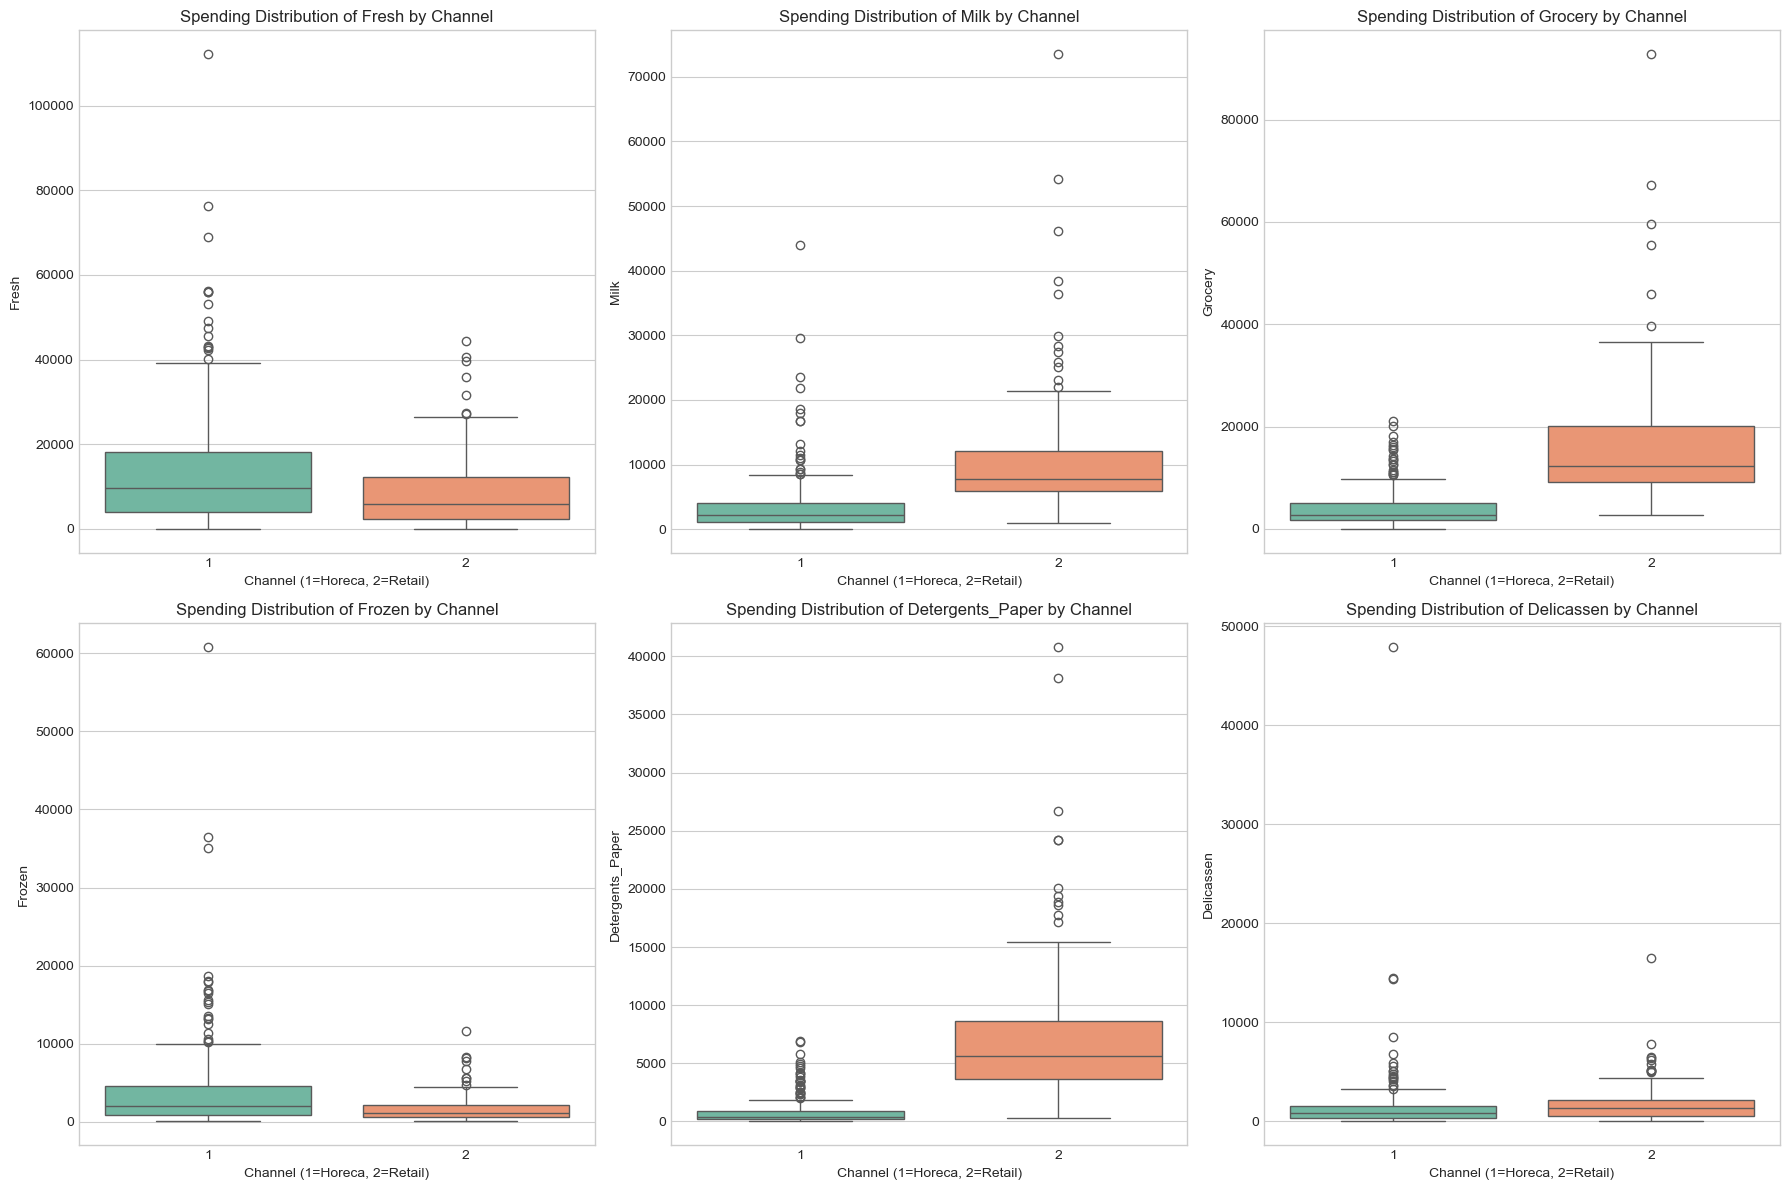

In [95]:
# Create a list of the 6 spending features
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.style.use('seaborn-v0_8-whitegrid')

# Flatten the axes array for easy iteration (0,0, 0,1, 0,2, 1,0, 1,1, 1,2)
axes = axes.flatten()

# Loop through each spending feature and plot its distribution by Channel
for i, feature in enumerate(spending_features):
    # The corrected line (assigning hue=x and setting legend=False):
    sns.boxplot(x='Channel', y=feature, data=df, ax=axes[i], palette='Set2', hue='Channel', legend=False)
    axes[i].set_title(f'Spending Distribution of {feature} by Channel')
    axes[i].set_xlabel('Channel (1=Horeca, 2=Retail)')

plt.tight_layout()
plt.show()

## Data Preparation

## Log Transformation

In [96]:
# Apply log transformation to all 6 spending columns
spending_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# We add 1 before taking the log (log(x+1)) to handle any potential zero values
# (though zero is unlikely for annual spending, it's good practice)
df_log = df.copy()
df_log[spending_features] = np.log1p(df_log[spending_features])

# The clustering analysis will be performed on df_log

# Save the original Channel and Region BEFORE encoding
original_channel = df_log['Channel'].copy()
original_region = df_log['Region'].copy()

## Standard Scaling

In [97]:
# 1. Categorical Encoding (One-Hot Encoding)
# We convert 'Channel' and 'Region' into binary columns (dummies)
df_encoded = pd.get_dummies(df_log, columns=['Channel', 'Region'], drop_first=False)

# Note: If you used drop_first=False above (as shown in the code), you keep all columns
# For clustering, keeping all dummy columns is often fine, but let's select ALL for safety:
X_features = df_encoded.columns

# 3. Apply Standard Scaling
scaler = StandardScaler()

# Fit and transform the data
X_scaled_array = scaler.fit_transform(df_encoded[X_features])

# Convert the array back to a DataFrame for easier handling in the next steps (PCA)
X_scaled = pd.DataFrame(X_scaled_array, columns=X_features)

print("Shape of the scaled data (X_scaled):", X_scaled.shape)
print("\nFirst 5 rows of the scaled data:")
print(X_scaled.head())

Shape of the scaled data (X_scaled): (440, 11)

First 5 rows of the scaled data:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen  \
0  0.486184  0.976299  0.440155 -1.509250          0.644143    0.408966   
1  0.087889  0.990956  0.652171  0.134052          0.766043    0.627926   
2  0.016356  0.891151  0.454687  0.376899          0.804405    1.776833   
3  0.517477 -0.957973 -0.084792  1.141574         -0.328712    0.633133   
4  0.880631  0.439662  0.395847  0.757322          0.404939    1.456588   

   Channel_1  Channel_2  Region_1  Region_2  Region_3  
0  -1.448652   1.448652 -0.460566 -0.345822  0.626422  
1  -1.448652   1.448652 -0.460566 -0.345822  0.626422  
2  -1.448652   1.448652 -0.460566 -0.345822  0.626422  
3   0.690297  -0.690297 -0.460566 -0.345822  0.626422  
4  -1.448652   1.448652 -0.460566 -0.345822  0.626422  


## Dimension Reduction using PCA

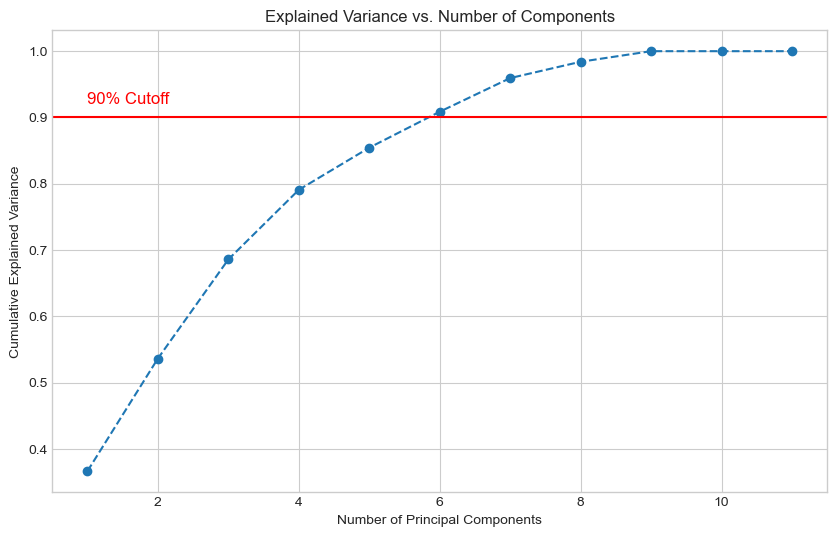


Total Features: 11
Number of components needed to explain 90% variance: 6

Shape of the final PCA data (X_pca): (440, 6)


In [98]:
# 1. Initialize PCA
# Setting n_components=None tells PCA to keep all components, 
# allowing us to analyze the explained variance ratio first.
pca = PCA(n_components=None, random_state=42)

# 2. Fit PCA to the scaled data
pca.fit(X_scaled)

# 3. Analyze Explained Variance
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance to find the 'elbow' (where the curve flattens)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(1, 0.92, '90% Cutoff', color = 'red', fontsize=12)
plt.grid(True)
plt.show()

# 4. Find the optimal number of components for 90% variance
n_components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1
print(f"\nTotal Features: {X_scaled.shape[1]}")
print(f"Number of components needed to explain 90% variance: {n_components_90}")

# 5. Apply PCA with the optimal number of components
pca_final = PCA(n_components=n_components_90, random_state=42)
X_pca = pca_final.fit_transform(X_scaled)

print(f"\nShape of the final PCA data (X_pca): {X_pca.shape}")

## Determine the optimal number of clusters

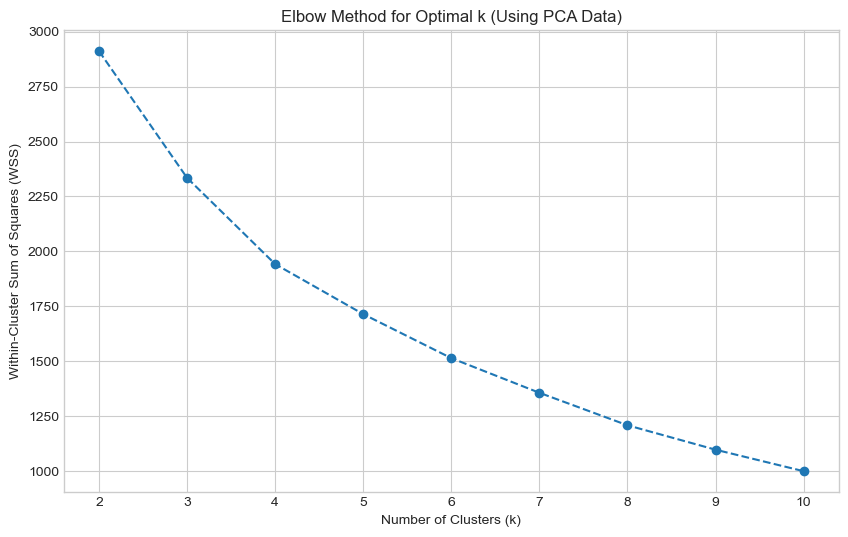

In [99]:
# Define the range of k values to test
k_range = range(2, 11) 
wss = [] # List to hold the WSS values

# Loop through the range of k values
for k in k_range:
    # Initialize KMeans with the current k
    # We use n_init=200 for a robust result
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=200, random_state=42)
    
    # Fit the model to the PCA data
    kmeans.fit(X_pca)
    
    # Append the WSS (inertia_) to the list
    wss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (Using PCA Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

## Calculate the Silhouette Score

In [100]:
# Define the range of k values to test
k_range = range(2, 11) 
silhouette_scores = {} # Dictionary to hold k: score pairs

# Loop through the range of k values
for k in k_range:
    # Initialize and fit KMeans (using the robust parameters)
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=200, random_state=42)
    kmeans.fit(X_pca)
    
    # Calculate the Silhouette Score
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores[k] = score

# Convert results to a DataFrame for clean presentation
scores_df = pd.DataFrame(list(silhouette_scores.items()), columns=['k', 'Silhouette_Score']).set_index('k')

print("Silhouette Scores for k=2 to k=10:")
print(scores_df)

Silhouette Scores for k=2 to k=10:
    Silhouette_Score
k                   
2           0.354736
3           0.358318
4           0.398673
5           0.299190
6           0.322746
7           0.341163
8           0.329810
9           0.337775
10          0.340652


## Fit the data

In [101]:
# K-Means clustering with optimal k=4
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=200, random_state=42)

# FIX: Fit the model on the PCA-transformed data (X_pca)
kmeans.fit(X_pca)

y_pred = kmeans.labels_

# Add the cluster labels to your log-transformed DataFrame
# This is correct for later interpretation
df_log['Cluster'] = y_pred
df_log['Channel'] = original_channel 
df_log['Region'] = original_region     

## ARI Calculation

In [102]:
true_labels = df_log['Channel']
ari_score = adjusted_rand_score(true_labels, y_pred)
print(f"ARI Score: {ari_score:.4f}")

ARI Score: 0.5278


In [103]:
cluster_analysis = df_log.groupby('Cluster').mean(numeric_only=True)
print(cluster_analysis)

          Channel    Region     Fresh      Milk   Grocery    Frozen  \
Cluster                                                               
0        1.991736  2.752066  8.383060  9.066954  9.537544  6.774038   
1        1.048387  1.000000  8.970684  7.785097  7.994540  7.621853   
2        1.000000  3.000000  8.905583  7.703403  7.884844  7.484493   
3        1.404255  2.000000  8.547504  8.000397  8.703162  7.434449   

         Detergents_Paper  Delicassen  
Cluster                                
0                8.610746    6.971592  
1                6.128346    6.561360  
2                5.903548    6.535186  
3                6.952788    6.649480  


## Cluster visulisation

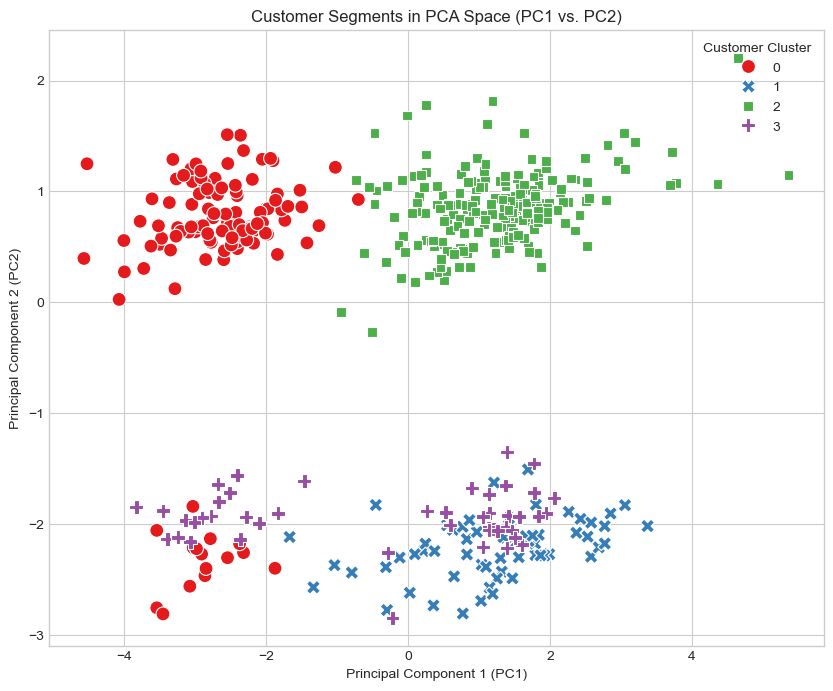

In [104]:
# 1. Create a DataFrame for plotting using the first two Principal Components (PC1 and PC2)
pca_df = pd.DataFrame(X_pca[:, 0:2], columns=['PC1', 'PC2'])
pca_df['Cluster'] = y_pred 

# 2. Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df, 
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    palette='Set1', 
    style='Cluster',
    s=100
)

plt.title('Customer Segments in PCA Space (PC1 vs. PC2)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend(title='Customer Cluster', loc='upper right')
plt.grid(True)
plt.show()

## Confusion Matrix

In [110]:
## Confusion Matrix - CLEAN VERSION
true_labels = df_log['Channel']

# Create confusion matrix (will be 4x4 with empty rows 0 and 3)
cm_full = confusion_matrix(true_labels, y_pred)

# Extract only rows 1 and 2 (Channel 1 and Channel 2)
cm = cm_full[1:3, :]  # Rows 1-2, all columns

print("Confusion Matrix (2x4):")
print(cm)
print(f"Shape: {cm.shape}")

print("\n" + "="*70)
print("FINAL Confusion Matrix (True Channel vs. Predicted Clusters):")
print("="*70)
print(f"{'Channel':<15} | Cluster 0 | Cluster 1 | Cluster 2 | Cluster 3 | Total")
print("-"*70)
print(f"{'Horeca (1)':<15} | {cm[0,0]:^9} | {cm[0,1]:^9} | {cm[0,2]:^9} | {cm[0,3]:^9} | {cm[0].sum():^5}")
print(f"{'Retail (2)':<15} | {cm[1,0]:^9} | {cm[1,1]:^9} | {cm[1,2]:^9} | {cm[1,3]:^9} | {cm[1].sum():^5}")
print("="*70)

Confusion Matrix (2x4):
[[  1  59 210  28]
 [120   3   0  19]]
Shape: (2, 4)

FINAL Confusion Matrix (True Channel vs. Predicted Clusters):
Channel         | Cluster 0 | Cluster 1 | Cluster 2 | Cluster 3 | Total
----------------------------------------------------------------------
Horeca (1)      |     1     |    59     |    210    |    28     |  298 
Retail (2)      |    120    |     3     |     0     |    19     |  142 
